# About This Notebook

The purpose of this notebook is to break up the Smith Purcell simulation in meep step by step.  There may have been modifications to the main .py file for the simulator since this notebook was written, but the core simulation routine should be the same.  

This is hopefully helpful in familiarizing a new meep user with how such a simulation works, and inspire them on how to modify the code for their own purposes if needed.

## Headers, Functions and Constants

In [130]:
#Headers
import meep as mp
import numpy as np
import h5py
from mpi4py import MPI
import meep.materials as meepmat

#Constants
# -- Units noted.  
# -- Fundamental unit length of 1-um assumed for meep calculations (see meep manual)
tcon = 3.33564 #time conversion to meep units (fs/meep time)
q =  1.6e-19 # electron charge in coulomb
m =  9.10938356e-31 # electron mass in kg 

#Functions

#Functions for calculating index of refraction -- meep style
def calc_sig_d(n, k, fcen):
    eps = (n + 1j*k)**2
    eps_r = np.real(eps)
    return 2*np.pi*fcen*np.imag(eps)/eps_r

def calc_eps_r(n, k):
    eps = (n + 1j*k)**2
    return np.real(eps)



## Settings for our Calculations

### Output File Settings

In [131]:
save_prefix = 'test_sim'

### Grating Settings

In [132]:
#Grating Structure Properties
grating_N = 10 #No. of grating elements
grating_period = 0.1 #grating period in um
grating_height = 0.02 #grating height in um
grating_fill_factor = 0.5 #fill-factor from 0 to 1

#If you want another grating under the underlayer...
lower_grating_height = 0.02

#Grating Material Properties
grating_material_eps = 13.5
want_grating_material_by_name = True
grating_material_name = 'Au'

#Grating fill material properties
# -- This is the material between each "tooth" of the grating
grating_fill_material_eps = 1.0
want_grating_fill_material_by_name = False
grating_fill_material_name = 'Au'

#This underlayer is a layer of the grating type of whatever thickness. This is more for traditional
#metalic gratings on-top of a planar film.  
# -- Can set to 0 thickness if you do not want it
underlayer_thick = 0.03
want_underlayer_material_by_name = True
underlayer_material_eps = 1.0
underlayer_material_name = 'Au'


#Substrate Material (semi-infinite film underneath grating):
substrate_material_eps = 1.55**2

### Electron Settings

In [133]:
e_height = 0.01 #Height of electron above grating surface (um)
W_e = 4e3 # Kinetic energy of electron (eV)

### FDTD-Specific Settings

These are important simulation parameters for running the FDTD simulation.

There are six basic components to every simulation.  I find that if I just note to take care of these three components one by one, I create simulations very quickly without any major issues.

1. The cell.  This is the world the simulation runs in.  I like to define the cell as being composed of an "active region" and a "boundary region".  The active region is defined by sizes `sx`, `sy`, and `sz`.  For a two-dimensional simulation you can simply make `sz = 0`.  The full cell is then defined by `sX`, `sY`, `sZ`. The full cell is typically slightly enlarged as you often place PMLs around the boundary of the active region. Note these are personal convention -- meep sees everything as being inside one cell.
2. Geometry. This is the definition of the optical properties of each voxel inside the simulation.  There are convenience shapes (blocks, spheres, cones, etc.) that can be used to help you define this.  There is also a way to simply pass your own functions to define optical properties at each voxel.   
3. Sources.  Inside the active region you typically place sources and monitors (see point 3).  The sources are essentially all comprised of some oscillating current either at a point, over a line, or over a sheet.  By manipulating these sources with phase-profiles you can create plane-waves, dipoles, etc.  
4. Monitors.  The monitors do exactly as they say -- they monitor the fields over a certain region in space.  These can be at a point, over a line, over a sheet, or over a volume.  You can place as many as you like, and use them to monitor fields of any type and in any specified polarization.  You choose this at the output.  
5. Fluxes. This is a compliment to monitors.  You can technically monitor the fields and use these to calculate power spectral densities, but meep has these flux components to do this for you and in a more sophisticated and accurate way.  You specify a sheet over which to monitor the flux.  This is essentially the power spectral density through a specified region calculated internally using the pointing vector.  
6. The run sequence.  This is the final step.  The simulator is calculating a lot of data on each iterative step of the FDTD process.  The run sequence allows you to tell it what you want to do at each step, how you want the simulation to be run, and what data to actually pull out and save.  This is extremely useful as it gives you the opportunity to tell the code what is worth keeping and what is not so that you don't save things you do not need.  You can also use this to do hack the simulator at each simulation step and do extra calculations beyond those typically performed in FDTD analysis.  

My strategy is to typically draw out my simulation by hand on paper.  I define my geometry using the basic provided shapes (or function if needed).  I then place my sources, monitors, and fluxes where they should go depending on what I want to calculate and where.  Finally, I think of my boundary conditions and where I would like to place PMLs, etc.  

In [134]:
#Simulation Parameters
# -- These parameters are important to running the simulation

#Is this the reference simulation?
reference = False

#PML Thicknesses
dpml = 0.5;

#Monitor settings
monitor_width = 5 #Width in no. of gratings
monitor_height = 1.0 #height as a ratio of cell size

# Sampling time for monitors in fs
t_sample = 0.5 

#EPS Averaging in Meep Calculation
avgeps = True

#Source Terms
src_offset = 0.001 # offset of source to material edge

#Perfectly Matched Layers
dpml = 1.0 #PML thickness around simulation

#Cell height (without PMLs)
sy = 5 # size of y-dimension

#Spatial Resolution
res = 200 # Resolution: points per meep-unit
        # e.g. if using 1 meep unit = 1 um,
        # 1/res um spacing
        

### Frequency Output Range

In [135]:
#Frequency range for calculations
fcen  = 2.0 #Central frequency (inverse wavelength in um)
nfreq  = 1000 #Number of frequency samples
df  = 1.9*fcen #Bandwidth of simulation

## Calculated Parameters

These are remaining parameters that are calculated based on user inputs.

### Calculate Remaining Cell Sizes

We want to calculate the active cell width `sx` as it depends on the number of grating periods we include in our simulation and it is all well-defined.  We will also then calculate the total cell sizes `SX`, `SY`.  The z-sizes are all 0 for our 2D simulation here. 

In [136]:
#Determine overall simulation cell size
sx  = grating_period*grating_N*2.0 #Width of the cell in um

#Full simulation cell sizes accounting for PMLs
sX = 2.0*dpml+ sx
sY = 2.0*dpml + sy
sZ = 0.0

### Electron Velocity

In [137]:
v_e = 1e6*1e-15*tcon*np.sqrt(2.0*q*W_e/m)

## Setup the FDTD Simulation

### Define Materials

In [138]:
if(want_grating_material_by_name):
    grating_material = eval('meepmat.' + grating_material_name)
else:
    grating_material = mp.Medium(epsilon=grating_material_eps)
    
if(want_grating_fill_material_by_name):
    grating_fill_material = eval('meepmat.' + grating_fill_material_name)
else:
    grating_fill_material = mp.Medium(epsilon=grating_fill_material_eps)
    
if(want_underlayer_material_by_name):
    underlayer_material = eval('meepmat.' + underlayer_material_name)
else:
    underlayer_material = mp.Medium(epsilon=underlayer_material_eps)


substrate_material = mp.Medium(epsilon=substrate_material_eps)

### Define the Geometry

In [139]:
# -- Cell --
cell_size = mp.Vector3(sX, sY, sZ)

# -- Geometry --
geometry = []

#Substrate Block
geometry.append(mp.Block(center=mp.Vector3(0.0,
                                           float(-0.25*sY),
                                           0.0),
                         size=mp.Vector3(mp.inf,
                                         float(0.5*sY),
                                         mp.inf),
                         material=substrate_material))

#Grating Fill Block
geometry.append(mp.Block(center=mp.Vector3(0.0,
                                           float(0.5*grating_height),
                                           0.0),
                         size=mp.Vector3(mp.inf,
                                         float(grating_height),
                                         mp.inf),
                         material=grating_fill_material))

#Underlayer Block
geometry.append(mp.Block(center=mp.Vector3(0.0,
                                           float(-0.5*underlayer_thick),
                                           0.0),
                         size=mp.Vector3(mp.inf,
                                         float(underlayer_thick),
                                         mp.inf),
                         material=underlayer_material))


if(not(reference)):

    #Loop through and create all desired objects...
    for i in range(grating_N):

        #Upper Grating
        geometry.append(mp.Block(center=mp.Vector3(float(grating_N*grating_period*-0.5 + grating_period*0.25 + i*grating_period),
                                                   float(grating_height*0.5),
                                                   0.0),
                                 size=mp.Vector3(float(grating_period*grating_fill_factor),
                                                 float(grating_height),
                                                 mp.inf),
                                 material=grating_material))
        
        #Lower Grating
        geometry.append(mp.Block(center=mp.Vector3(float(grating_N*grating_period*-0.5 + grating_period*0.25 + i*grating_period),
                                                   float(lower_grating_height*-0.5 - underlayer_thick),
                                                   0.0),
                                 size=mp.Vector3(float(grating_period*grating_fill_factor),
                                                 float(lower_grating_height),
                                                 mp.inf),
                                 material=grating_material))       


### Boundary Conditions

In [140]:
# -- Periodic Bdr. Cond -- 
k_point = mp.Vector3(0, 0, 0)

### Symmetries

This simulation does not have symmetry.  However, you should note that if your simulation has symmetry, then you can speed up the simulation significantly by including it. 

This symmetry is NOT symmetry of the objects, but of the fields.  If it is inversion symmetric, then you can include a negative pre-factor to account for it.  

### Define the PML Layers

In [141]:
 # -- PML Layers --
pml_layers = [mp.PML(thickness=np.double(dpml), direction=mp.X),
              mp.PML(thickness=np.double(dpml), direction=mp.Y),
              mp.PML(thickness=np.double(dpml), direction=mp.Z)]

### Define the Field Monitors

In [142]:
#Create a "volume" monitor (technically 2D as z = 0) for fields:
monitor_xy = mp.Volume(center=mp.Vector3(0, 0),
                                   size=mp.Vector3(monitor_width*grating_period, monitor_height*sy, 0))

### Sources

Here will will have a delta source that is a point current source with zero size.  This reflects a moving charge in space.

In [143]:
#Y-Polarized Gaussian source next to the dpml at -0.5 sz
sources = [mp.Source(mp.ContinuousSource(frequency=1e-10),
                     component=mp.Ex,
                     center=mp.Vector3(sx*-0.5, grating_height+e_height),
                     size=mp.Vector3(0,0,0))]


### Define our Simulation

In [144]:
 # -- Load Settings Into Simulation -- 
sim = mp.Simulation(resolution=res,
                    cell_size=cell_size,
                    boundary_layers=pml_layers,
                    sources=sources,
                    k_point=k_point,
                    geometry=geometry,
                    dimensions=2,
                    filename_prefix=save_prefix)

### Define and Add the Flux Regions

We define the flux regions and add them to our simulation.

In [145]:
#Air Side
air_fr = mp.FluxRegion(center=mp.Vector3(0, sy*0.05, 0), 
                       size=mp.Vector3(sx, 0, 0),
                       direction=mp.Y)
air_flux = sim.add_flux(fcen, df, nfreq, air_fr)

#Substrate Side
substrate_fr = mp.FluxRegion(center=mp.Vector3(0, -1*sy*0.05, 0), 
                       size=mp.Vector3(sx, 0, 0),
                       direction=mp.Y)
substrate_flux = sim.add_flux(fcen, df, nfreq, substrate_fr)



## Run the Simulation

Now we have it all setup -- we just have to run the simulation.

In [146]:

#Step function for moving the source with time given the electron velocity:
def move_source(sim):
    sim.change_sources([mp.Source(mp.ContinuousSource(frequency=1e-10),
                                  component=mp.Ex,
                                  center=mp.Vector3(-0.5*sx + v_e*sim.meep_time(), 
                                                    grating_height + e_height,
                                                    0),
                                  size=mp.Vector3(0,0,0))])

# -- Run Simulation -- 
sim.run(move_source,
        mp.at_beginning(mp.output_epsilon),
        mp.in_volume(monitor_xy,
                     mp.to_appended("Ex_xy",
                                    mp.at_every(t_sample/tcon, mp.output_efield_x))),
        mp.in_volume(monitor_xy,
                     mp.to_appended("Ey_xy",
                                    mp.at_every(t_sample/tcon, mp.output_efield_y))),
        until = sx/v_e)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00882316 s
Working in 2D dimensions.
Computational cell is 4 x 7 x 0 with resolution 200
     block, center = (0,-1.75,0)
          size (1e+20,3.5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.4025,2.4025,2.4025)
     block, center = (0,0.01,0)
          size (1e+20,0.02,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.015,0)
          size (1e+20,0.03,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (-0.475,0.01,0)
          size (0.05,0.02,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (-0.475,-0.04,0)
          size (0.05,0.02,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (

/home/dkeathley/anaconda3/envs/pymeep/lib/python3.9/site-packages/meep/simulation.py:1343: RuntimeWarning: Note: your sources include frequencies outside the range of validity of the material models. This is fine as long as you eventually only look at outputs (fluxes, resonant modes, etc.) at valid frequencies.
  warnings.warn(warn_src, RuntimeWarning)
/home/dkeathley/anaconda3/envs/pymeep/lib/python3.9/site-packages/meep/simulation.py:1347: RuntimeWarning: DFT frequency 0.10000000000000009 is out of material's range of 0.16131113692089302-4.0327458966810505
  warnings.warn(warn_dft_fmt.format(dftf, min_freq, max_freq), RuntimeWarning)


creating output file "./test_sim-Ex_xy.h5"...
creating output file "./test_sim-Ey_xy.h5"...
Meep progress: 0.1075/15.995224211855438 = 0.7% done in 4.1s, 599.8s to go
on time step 46 (time=0.115), 0.0900326 s/step
Meep progress: 0.2475/15.995224211855438 = 1.5% done in 8.1s, 516.3s to go
on time step 104 (time=0.26), 0.0694881 s/step
Meep progress: 0.3925/15.995224211855438 = 2.5% done in 12.1s, 482.9s to go
on time step 162 (time=0.405), 0.0695776 s/step
Meep progress: 0.5375/15.995224211855438 = 3.4% done in 16.2s, 465.3s to go
on time step 220 (time=0.55), 0.0695529 s/step
Meep progress: 0.675/15.995224211855438 = 4.2% done in 20.2s, 458.5s to go
on time step 275 (time=0.6875), 0.0729669 s/step
Meep progress: 0.8175/15.995224211855438 = 5.1% done in 24.2s, 450.1s to go
on time step 331 (time=0.8275), 0.0737854 s/step
Meep progress: 0.9525/15.995224211855438 = 6.0% done in 28.3s, 447.1s to go
on time step 387 (time=0.9675), 0.0721615 s/step
Meep progress: 1.0975/15.995224211855438 = 

## Analyze the Outputs

### Plot Power Out

2.4025000000000003

-566.2872510454871

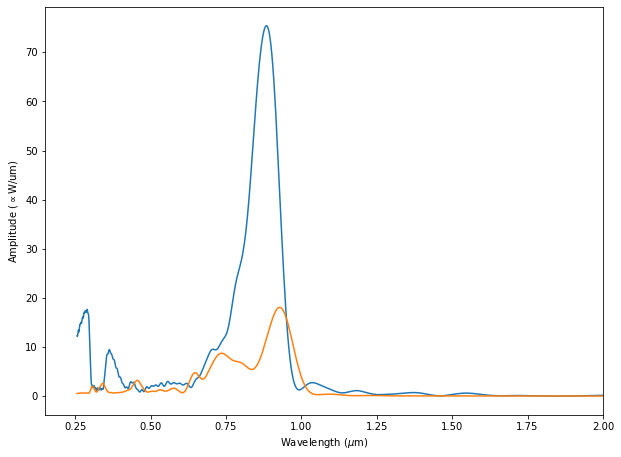

In [147]:
import matplotlib.pyplot as plt

air_flux_out = mp.get_fluxes(air_flux)
substrate_flux_out = mp.get_fluxes(substrate_flux)
flux_freqs = mp.get_flux_freqs(air_flux)


lam = 1.0/np.array(flux_freqs)
d_lam = -1*np.diff(lam)
d_lam = np.append(d_lam, d_lam[-1])

#Plot the wavelength spectrum:
fig = plt.figure()
plt.plot(lam, air_flux_out/d_lam)
plt.plot(lam, -1.0*np.array(substrate_flux_out)/d_lam)
plt.xlim(0.15, 2.0)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Amplitude ($\propto$W/um)')

fig.set_size_inches(10, 7.5)

display(substrate_material_eps)
display((1/0.1 + 1/0.9 - v_e/0.1)/(1/0.9 - v_e/0.1)/v_e)




TypeError: Wrong number or type of arguments for overloaded function 'dft_flux_save_hdf5'.
  Possible C/C++ prototypes are:
    meep::dft_flux::save_hdf5(meep::h5file *,char const *)
    meep::dft_flux::save_hdf5(meep::h5file *)
    meep::dft_flux::save_hdf5(meep::fields &,char const *,char const *,char const *)
    meep::dft_flux::save_hdf5(meep::fields &,char const *,char const *)
    meep::dft_flux::save_hdf5(meep::fields &,char const *)
